<a href="https://colab.research.google.com/github/azhelyazkova/demo2/blob/main/spark101_demo_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Spark 101

## What is Spark?

The golden standard powering a modern Big Data Platform, Spark is a multi-language engine for executing data engineering, data science, and machine learning jobs on single-node machines or clusters.


## Distributed Computing

The power behind Spark is distributed computing. Thanks to its architecture, Spark is able to split up the execution of a job on multiple nodes (in more simplified terms, multiple computers).

### How does distribution work
Let's looks at a simple example.
Imagine yourselves in a classroom.
Your Professor takes out a big bag of M&M packages and asks you to count the total number of candy pieces in all packages.

**What strategy would you use?**

###Slido Event Code
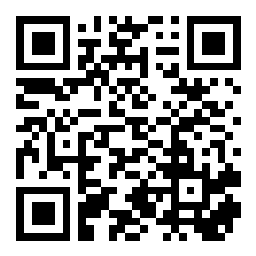


## Spark Application Architecture

### Driver
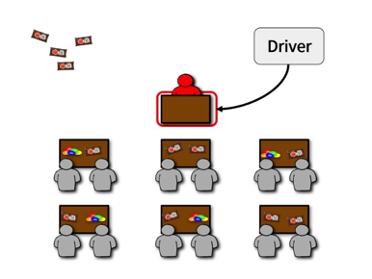

A Spark application consists of a Driver Node which controls the execution of tasks and their distribution to the executor nodes which actually perform the calculations.

The job of the Driver is to keep track of all running tasks on all executors and to allocate the tasks to the workers based on the available resources.

The Driver is in charge of all the tasks but doesn't actually process the data. It is responsible for assigning the tasks to the workers.

### Executors / Nodes

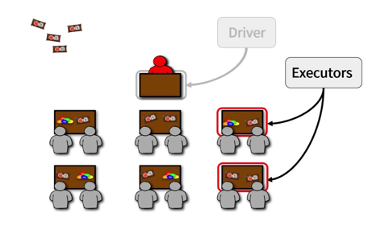

You can think of the Executors as the environments in which the tasks are run. The executors are Java Vritual Machines (JVMs). They are the main application space where the code is running as we are processing our data. They are the ones actually running the tasks that the Driver assigns to them.

Executors run in Nodes - the actual virtual machines or physical machines that provide the resources that are required for the Spark application to run - RAM and cores. It is good practice to run 1 executor per node for greater stability - in this way, we do not have more than 1 executors competing for the same resources. This is why the terms Executor and Node are often conflated.


### Spark Cluster
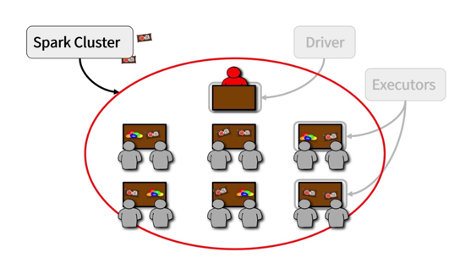

The Driver and the Executors combined form the Spark Cluster.

### Slots / Threads / Cores
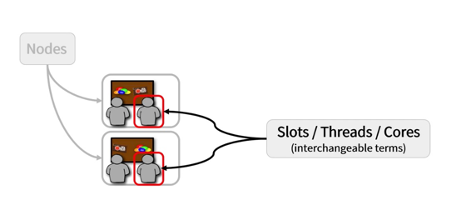

Each node has a certain number of cores which are available to run tasks. If we have 1 executor/node with 4 cores, it will be able to run 4 threads (tasks) - 1 on each core.
From the Driver's perspective, the core is a slot to which it can assign tasks.
The number of cores we have determine the number of tasks that Spark can run in parallel.

### Shared Resources  

The threads are sharing resources across the node - RAM, Disk, Network.
If we go with the M&M analogy, the students are sharing the physical space (the desk) -> they might be sharing the pen/paper or whatever device they use to tally the numbers.

Sharing is contained within the node - resources are not shared across the node.
Therefore, if your partner on the table consumes all the RAM, you will run out of RAM. Or if they consume the disk, you will have disk issues.
If one thread exhausts all the available resources (e.g. RAM - creating an Out of Memory error), this will bring down the entire executor, causing every process running on that executor to fail.

However, the tasks on the other executors will continue to run.

# Configuration

## Install Dependencies

Installing the latest version of PySpark in a Google Colab notebook is relatively straightforward. Google Colab comes with Python pre-installed, but you'll often need to install additional libraries yourself.

In our demo, we need to install `pyspark` as well as the `delta-spark` libraries. Pyspark will allow us to process big data while delta-spark will allow us to store it and manage it efficiently.

Delta Lake is the open-source storage layer that is used a lot in the enterprise. Essentially, it provides a more structured and reliable way to store and manage vast amounts of data, enabling features like **versioned data history, rollbacks, and full data consistency**. This makes it easier for data engineers and scientists to build reliable data pipelines and perform complex data analytics, all while working with big data in a more efficient and controlled manner.

Here's how you can install the dependencies:

In [1]:
!pip install pyspark delta-spark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b1ef132f4031ec27595abe0ed2c69c8842a883cfb52741de36dde48ba8bc876b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


## Setting Up Spark Environment (Optional):
After installing PySpark, you might want to set up some environment variables for Spark and Java. However, this is optional because PySpark can automatically find the necessary Java dependencies in most environments like Google Colab. If you encounter any issues related to Java, you might need to install Java and set the JAVA_HOME environment variable. Here's how you could do it:

In [2]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

## Start Spark Session

In [3]:
from pyspark.sql import SparkSession

builder = SparkSession.builder.appName("DeltaTableExample") \
    .master("local[*]") \
    .config("spark.jars.packages", "io.delta:delta-spark_2.12:3.1.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = builder.getOrCreate()

print(spark.version)  # This should print the version of Spark you've installed.

3.5.1


## Mount your Google Drive to get access to all your files

When you run the cell below, you will be prompted to authorize access to your Google Drive.  
Follow the instructions to allow Colab to access your Drive.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [6]:
!wget -nc -P /content/gdrive/MyDrive/colab_demo_2024 https://files.grouplens.org/datasets/movielens/ml-25m.zip

File ‘/content/gdrive/MyDrive/colab_demo_2024/ml-25m.zip’ already there; not retrieving.



In [7]:
![ ! -d "/content/gdrive/MyDrive/colab_demo_2024/MovieLens25M/ml-25m" ] && unzip -o /content/gdrive/MyDrive/colab_demo_2024/ml-25m.zip -d /content/gdrive/MyDrive/colab_demo_2024/MovieLens25M

Archive:  /content/gdrive/MyDrive/colab_demo_2024/ml-25m.zip
   creating: /content/gdrive/MyDrive/colab_demo_2024/MovieLens25M/ml-25m/
  inflating: /content/gdrive/MyDrive/colab_demo_2024/MovieLens25M/ml-25m/tags.csv  
  inflating: /content/gdrive/MyDrive/colab_demo_2024/MovieLens25M/ml-25m/links.csv  
  inflating: /content/gdrive/MyDrive/colab_demo_2024/MovieLens25M/ml-25m/README.txt  
  inflating: /content/gdrive/MyDrive/colab_demo_2024/MovieLens25M/ml-25m/ratings.csv  
  inflating: /content/gdrive/MyDrive/colab_demo_2024/MovieLens25M/ml-25m/genome-tags.csv  
  inflating: /content/gdrive/MyDrive/colab_demo_2024/MovieLens25M/ml-25m/genome-scores.csv  
  inflating: /content/gdrive/MyDrive/colab_demo_2024/MovieLens25M/ml-25m/movies.csv  


# Examine Data

In [8]:
!ls -l /content/gdrive/MyDrive/colab_demo_2024/MovieLens25M/ml-25m

total 1129563
-rw------- 1 root root 435164157 Nov 21  2019 genome-scores.csv
-rw------- 1 root root     18103 Nov 21  2019 genome-tags.csv
-rw------- 1 root root   1368578 Nov 21  2019 links.csv
-rw------- 1 root root   3038099 Nov 21  2019 movies.csv
-rw------- 1 root root 678260987 Nov 21  2019 ratings.csv
-rw------- 1 root root     10460 Nov 21  2019 README.txt
-rw------- 1 root root  38810332 Nov 21  2019 tags.csv


# Movies

In [9]:
movies = (
  spark
  .read
  .format("csv")
  .option("header", "true")
  .option("delimiter", ",")
  .load("/content/gdrive/MyDrive/colab_demo_2024/MovieLens25M/ml-25m/movies.csv")
    )

### Spark's lazy nature
A typical Spark application loads data from a data source, transforms it into an RDD and continues with some action.

Whenever we tell Spark to read a file, it actually just generates an action plan for how exactly to implement certain transformations (join, map, groupBy, etc.). However, it does not actually execute it until an action is called (count, show, collect, etc.) The data is loaded when we call an action.

Spark's lazy execution also contributes to its efficiency. The transformations are simply a step in a logical plan and each executor is aware of this plan.

Therefore, the first thing that happens is the generation of this logical plan. At this stage Spark does not even check the metadata (column names, formats, etc.) It does so at the next step - when it generates a resolved logical plan.

In [10]:
movies.count()

62423

In [11]:
movies.show(10, truncate=False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
|6      |Heat (1995)                       |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                    |Comedy|Romance                             |
|8      |Tom and Huck (1995)               |Adventure|Children                         |
|9      |Sudden Death

Generate some descriptive statistics of the data

In [12]:
#TODO
movies.describe().show()

+-------+------------------+--------------------+------------------+
|summary|           movieId|               title|            genres|
+-------+------------------+--------------------+------------------+
|  count|             62423|               62423|             62423|
|   mean|122220.38764557935|                NULL|              NULL|
| stddev| 63264.74484425327|                NULL|              NULL|
|    min|                 1|"""BLOW THE NIGHT...|(no genres listed)|
|    max|             99999|     줄탁동시 (2012)|           Western|
+-------+------------------+--------------------+------------------+



In [13]:
movies.summary().show()

+-------+------------------+--------------------+------------------+
|summary|           movieId|               title|            genres|
+-------+------------------+--------------------+------------------+
|  count|             62423|               62423|             62423|
|   mean|122220.38764557935|                NULL|              NULL|
| stddev| 63264.74484425327|                NULL|              NULL|
|    min|                 1|"""BLOW THE NIGHT...|(no genres listed)|
|    25%|           82121.0|                NULL|              NULL|
|    50%|          138010.0|                NULL|              NULL|
|    75%|          173215.0|                NULL|              NULL|
|    max|             99999|     줄탁동시 (2012)|           Western|
+-------+------------------+--------------------+------------------+



In [14]:
movies.write.format("delta").saveAsTable("movies_raw")

In [15]:
spark.sql("select * from movies_raw").show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

# Ratings

In [21]:
ratings = (
  spark
  .read
  .format("csv")
  .option("header", "true")
  .option("delimiter", ",")
  .load("/content/gdrive/MyDrive/colab_demo_2024/MovieLens25M/ml-25m/ratings.csv")
    )

In [17]:
ratings.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
|     1|   1088|   4.0|1147868495|
|     1|   1175|   3.5|1147868826|
|     1|   1217|   3.5|1147878326|
|     1|   1237|   5.0|1147868839|
|     1|   1250|   4.0|1147868414|
|     1|   1260|   3.5|1147877857|
|     1|   1653|   4.0|1147868097|
|     1|   2011|   2.5|1147868079|
|     1|   2012|   2.5|1147868068|
|     1|   2068|   2.5|1147869044|
|     1|   2161|   3.5|1147868609|
|     1|   2351|   4.5|1147877957|
|     1|   2573|   4.0|1147878923|
|     1|   2632|   5.0|1147878248|
|     1|   2692|   5.0|1147869100|
+------+-------+------+----------+
only showing top 20 rows



In [18]:
ratings.write.format("delta").saveAsTable("ratings_raw")

## Users

In [20]:
#TODO
# remember to specify header and delimiter
tags = (
  spark
  .read
  .format("csv")
  .option("header", "true")
  .option("delimiter", ",")
  .load("/content/gdrive/MyDrive/colab_demo_2024/MovieLens25M/ml-25m/tags.csv")
    )

In [22]:
tags.show()

+------+-------+--------------------+----------+
|userId|movieId|                 tag| timestamp|
+------+-------+--------------------+----------+
|     3|    260|             classic|1439472355|
|     3|    260|              sci-fi|1439472256|
|     4|   1732|         dark comedy|1573943598|
|     4|   1732|      great dialogue|1573943604|
|     4|   7569|    so bad it's good|1573943455|
|     4|  44665|unreliable narrators|1573943619|
|     4| 115569|               tense|1573943077|
|     4| 115713|artificial intell...|1573942979|
|     4| 115713|       philosophical|1573943033|
|     4| 115713|               tense|1573943042|
|     4| 148426|    so bad it's good|1573942965|
|     4| 164909|              cliche|1573943721|
|     4| 164909|             musical|1573943714|
|     4| 168250|              horror|1573945163|
|     4| 168250|       unpredictable|1573945171|
|    19|   2160|Oscar (Best Suppo...|1446909853|
|    19|   7099|           adventure|1445286141|
|    19|   7099|    

# Which brand has the most products in our data frame

In [23]:
from pyspark.sql import functions as F

#TODO
# group by the moving and get the avg

(
    ratings
    .groupBy("movieId")
    .agg(F.avg("rating").alias("avg_rating"))
    .orderBy(F.col("avg_rating").desc())
    .show()
)

+-------+----------+
|movieId|avg_rating|
+-------+----------+
| 170229|       5.0|
| 146487|       5.0|
| 196547|       5.0|
| 164153|       5.0|
| 169818|       5.0|
| 137964|       5.0|
| 193131|       5.0|
| 133013|       5.0|
| 133297|       5.0|
| 116243|       5.0|
| 169338|       5.0|
| 206967|       5.0|
| 193129|       5.0|
| 127345|       5.0|
| 134633|       5.0|
| 192351|       5.0|
| 178739|       5.0|
| 143833|       5.0|
| 159050|       5.0|
| 160028|       5.0|
+-------+----------+
only showing top 20 rows



# Data load and summary

In [26]:
## Random forest regressor
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator


''' Dataset Information :

    Input fields :
      Longitude: East/west measurement, a higher value is further west.
      Latitude: North/south measurement, a higher value is further north.
      Housing Median Age: Median age of a house within a block, lower is newer.
      Total Rooms: Total number of rooms within a block.
      Total Bedrooms: Total number of bedrooms within a block.
      Population: Total number of people residing within a block.
      Households: Total number of households in a block.
      Median Income: Median income for households within a block of houses (measured in tens of thousands of dollars).
      Median House Value: Median house value (in thousands of dollars) for households within a block.

    Created fields :
      In order to make some of the features more relevant for predicting the
      median house value, instead of using the totals the following ratios are
      created:
          - rooms per house=total rooms/households
          - people per house=population/households
          - bedrooms per rooms=total bedrooms/total rooms.

    Label/target column : "median_house_value"
    Features : {"median age", "median income", "rooms per house", "population per house", "bedrooms per room", "longitude", "latitude" }
'''

# Load and parse the data file, converting it to a DataFrame.
train_df= spark.read.csv(path="/content/sample_data/california_housing_train.csv",
                         inferSchema=True, header=True)

test_df = spark.read.csv(path="/content/sample_data/california_housing_test.csv",
                         inferSchema=True, header=True)

california_housing_df = train_df.union(test_df.select(train_df.columns))

# Create additional features
california_housing_df = california_housing_df.withColumn("rooms_per_house", F.col("total_rooms") / F.col("households"))
california_housing_df = california_housing_df.withColumn("pop_per_house", F.col("population") / F.col("households"))
california_housing_df = california_housing_df.withColumn("bedrooms_per_house", F.col("total_bedrooms") / F.col("total_rooms"))

california_housing_df=california_housing_df.drop("total_rooms", "households", "population" , "total_bedrooms")

In [27]:
# Dataframe statistics
# check schema
print("Schema california_housing_df : ")
print(california_housing_df.printSchema())

Schema california_housing_df : 
root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- rooms_per_house: double (nullable = true)
 |-- pop_per_house: double (nullable = true)
 |-- bedrooms_per_house: double (nullable = true)

None


In [28]:
# row count
print("Row count california_housing_df : ", california_housing_df.count())

Row count california_housing_df :  20000


In [29]:
# display one row of the train/test data
print("Display one row of the california_housing_df : ")
print(california_housing_df.limit(1).show())

Display one row of the california_housing_df : 
+---------+--------+------------------+-------------+------------------+------------------+------------------+-------------------+
|longitude|latitude|housing_median_age|median_income|median_house_value|   rooms_per_house|     pop_per_house| bedrooms_per_house|
+---------+--------+------------------+-------------+------------------+------------------+------------------+-------------------+
|  -114.31|   34.19|              15.0|       1.4936|           66900.0|11.889830508474576|2.1504237288135593|0.22861724875267284|
+---------+--------+------------------+-------------+------------------+------------------+------------------+-------------------+

None


In [30]:
# check Pearson correlation between median_house_value and median_income
california_housing_df.select(F.corr("median_house_value", "median_income")).show()

+---------------------------------------+
|corr(median_house_value, median_income)|
+---------------------------------------+
|                     0.6891094729577227|
+---------------------------------------+



# Model training

In [31]:
# Step 1 : Feature Extraction and Pipelining
############################################
from pyspark.ml.feature import VectorAssembler

feature_columns = [
                   'longitude',
                   'latitude',
                   'housing_median_age',
                   'median_income',
                   'rooms_per_house',
                   'pop_per_house',
                   'bedrooms_per_house'
]

# VectorAssembler is transformer that merges multiple columns into a vector column.
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
california_housing_df = assembler.transform(california_housing_df)
california_housing_df.limit(1).show(1, False)

+---------+--------+------------------+-------------+------------------+------------------+------------------+-------------------+-------------------------------------------------------------------------------------+
|longitude|latitude|housing_median_age|median_income|median_house_value|rooms_per_house   |pop_per_house     |bedrooms_per_house |features                                                                             |
+---------+--------+------------------+-------------+------------------+------------------+------------------+-------------------+-------------------------------------------------------------------------------------+
|-114.31  |34.19   |15.0              |1.4936       |66900.0           |11.889830508474576|2.1504237288135593|0.22861724875267284|[-114.31,34.19,15.0,1.4936,11.889830508474576,2.1504237288135593,0.22861724875267284]|
+---------+--------+------------------+-------------+------------------+------------------+------------------+-------------------+--

In [32]:
# Step 2 : RandomSplit of the data
############################################
print("Caching : ", california_housing_df.cache().count())

train_df, test_df = california_housing_df.randomSplit([0.8, 0.2], seed=42)
print(train_df.count(), test_df.count())

# ! Spark RandomSplit : https://medium.com/udemy-engineering/pyspark-under-the-hood-randomsplit-and-sample-inconsistencies-examined-7c6ec62644bc

Caching :  20000
16088 3912


In [33]:
# Step 3 : Train a RandomForest model.
############################################
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestRegressor(featuresCol="features", labelCol="median_house_value")
rfModel = rf.fit(train_df)

predictions = rfModel.transform(test_df)
predictions.select(feature_columns + ['median_house_value', 'prediction']).show(25)

+---------+--------+------------------+-------------+------------------+------------------+-------------------+------------------+------------------+
|longitude|latitude|housing_median_age|median_income|   rooms_per_house|     pop_per_house| bedrooms_per_house|median_house_value|        prediction|
+---------+--------+------------------+-------------+------------------+------------------+-------------------+------------------+------------------+
|   -124.3|   41.84|              17.0|       3.0313| 5.870614035087719|2.7280701754385963|0.19835636906985432|          103600.0|125911.39233930703|
|  -124.23|   40.54|              52.0|       3.0806|6.1931034482758625|2.6482758620689655|0.16815144766146994|          106700.0|130194.00633384466|
|  -124.23|   41.75|              11.0|       2.4805|6.5949895615866385|2.8037578288100207|0.19499841722063943|           73200.0| 94903.37020297306|
|  -124.19|   40.73|              21.0|       3.5363|5.8580246913580245| 2.990740740740741|0.1854583

In [40]:
# Step 4 : Model evaluation
############################################

def compute_RMSE(df, predicted_col, actual_col):
  rmse = (df
    .withColumn("squarederror", F.pow(F.col(actual_col) - F.col(predicted_col), F.lit(2)))
    .groupby()
    .agg(F.round(F.avg(F.col("squarederror")),4).alias("mse"))
    .withColumn("rmse", F.sqrt(F.col("mse")))
    )
  return rmse


print(compute_RMSE(df=predictions, predicted_col="prediction", actual_col="median_house_value").show())

+-----------------+----------------+
|              mse|            rmse|
+-----------------+----------------+
|4.7592050562486E9|68986.9919350641|
+-----------------+----------------+

None


In [41]:
# Step 5 : Baseline prediction
############################################
avg_pred = predictions.groupBy().agg(F.avg('median_house_value').alias('avg_prediction')).rdd.flatMap(lambda x: x).collect()[0]
predictions = predictions.withColumn('avg_prediction', F.lit(avg_pred))
predictions.show(1)
print(compute_RMSE(df=predictions, predicted_col="avg_prediction", actual_col="median_house_value").show())


+---------+--------+------------------+-------------+------------------+-----------------+------------------+-------------------+--------------------+------------------+------------------+
|longitude|latitude|housing_median_age|median_income|median_house_value|  rooms_per_house|     pop_per_house| bedrooms_per_house|            features|        prediction|    avg_prediction|
+---------+--------+------------------+-------------+------------------+-----------------+------------------+-------------------+--------------------+------------------+------------------+
|   -124.3|   41.84|              17.0|       3.0313|          103600.0|5.870614035087719|2.7280701754385963|0.19835636906985432|[-124.3,41.84,17....|125911.39233930703|207326.70782208588|
+---------+--------+------------------+-------------+------------------+-----------------+------------------+-------------------+--------------------+------------------+------------------+
only showing top 1 row

+-------------------+----------